## Requirements

In [ ]:
#Get datasets
!pip install kagglehub[pandas-datasets]

In [2]:
pip install hdbscan

In [3]:
pip install pyarrow

In [4]:
#Libraries
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import hdbscan
from scipy import stats
import time
import pyarrow
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cosine
from scipy.stats import entropy
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    adjusted_mutual_info_score
)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [5]:
#Load the dataset
file_path = "dataset.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "maharshipandya/-spotify-tracks-dataset",
  file_path,
)

/tmp/ipython-input-2434121773.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 8.17M/8.17M [00:00<00:00, 10.0MB/s]

Extracting zip of dataset.csv...


## Dataset exploration

In [6]:
df = df.drop(columns=['Unnamed: 0'])

In [7]:
df_cleaned = df.drop_duplicates('track_id', keep='first')
df = df_cleaned.copy()

In [8]:
extra_cols = ['track_id', 'artists', 'album_name', 'track_name', 'popularity','track_genre']
#Keep numerical features
feature_cols = ['duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
                'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                'valence', 'tempo', 'time_signature']

#Copy of features
features = df[feature_cols].copy()

#Standardise
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=feature_cols)

## Evaluation on full dataset

In [20]:
n_clusters_range = [15, 30, 60, 90, 113]
X = features_scaled_df.values.copy()

In [21]:
results = {
    'Algorithm': [],
    'n_clusters': [],
    'Silhouette': [],
    'Calinski_Harabasz': [],
    'Davies_Bouldin': [],
    'AIC': [],
    'BIC': [],
    'Log_Likelihood': [],
    'Effective_Clusters': [],
    'Inertia':[]
    }
fitted_models = {}
for k in n_clusters_range:
    print(f"Starting {k} cluster")
    print(f"KMeans")
    kmeans = KMeans(n_clusters=k, random_state=2000, n_init=20)
    labels_kmeans = kmeans.fit_predict(X)
    #Metrics KMeans
    results['Algorithm'].append('KMeans')
    results['n_clusters'].append(k)
    results['Silhouette'].append(silhouette_score(X, labels_kmeans))
    results['Calinski_Harabasz'].append(calinski_harabasz_score(X, labels_kmeans))
    results['Davies_Bouldin'].append(davies_bouldin_score(X, labels_kmeans))
    results['AIC'].append(np.nan)
    results['BIC'].append(np.nan)
    results['Inertia'].append(kmeans.fit(features_scaled_df).inertia_)
    results['Log_Likelihood'].append(np.nan)
    results['Effective_Clusters'].append(k)
    fitted_models[f'KMeans_k{k}'] = kmeans

    print(f"GMM")
    gmm = GaussianMixture(n_components=k, random_state=2000, n_init=10)
    labels_gmm = gmm.fit_predict(X)
    #Metrics GMM
    results['Algorithm'].append('GMM')
    results['n_clusters'].append(k)
    results['Silhouette'].append(silhouette_score(X, labels_gmm))
    results['Calinski_Harabasz'].append(calinski_harabasz_score(X, labels_gmm))
    results['Davies_Bouldin'].append(davies_bouldin_score(X, labels_gmm))
    results['AIC'].append(gmm.aic(X))
    results['BIC'].append(gmm.bic(X))
    results['Inertia'].append(np.nan)
    results['Log_Likelihood'].append(gmm.score(X) * len(X))
    results['Effective_Clusters'].append(k)
    fitted_models[f'GMM_k{k}'] = gmm

    print(f"BGMM")
    bgmm = BayesianGaussianMixture(n_components=k, random_state=2000, n_init=10)
    labels_bgmm = bgmm.fit_predict(X)
    #Count effective clusters (components with significant weight)
    effective_k_bgmm = np.sum(bgmm.weights_ > 0.01)
    #Metrics BGMM
    results['Algorithm'].append('BGMM')
    results['n_clusters'].append(k)
    results['Silhouette'].append(silhouette_score(X, labels_bgmm))
    results['Calinski_Harabasz'].append(calinski_harabasz_score(X, labels_bgmm))
    results['Davies_Bouldin'].append(davies_bouldin_score(X, labels_bgmm))
    results['AIC'].append(np.nan)  # BGMM doesn't have standard AIC
    results['BIC'].append(np.nan)  # BGMM uses variational lower bound instead
    results['Inertia'].append(np.nan)
    results['Log_Likelihood'].append(bgmm.score(X) * len(X))
    results['Effective_Clusters'].append(effective_k_bgmm)
    fitted_models[f'BGMM_k{k}'] = bgmm

Starting 15 cluster
KMeans
GMM
BGMM


/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Starting 30 cluster
KMeans
GMM
BGMM


/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Starting 60 cluster
KMeans
GMM
BGMM


/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Starting 90 cluster
KMeans
GMM
BGMM


/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Starting 113 cluster
KMeans
GMM
BGMM


/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


In [22]:
results_df = pd.DataFrame(results)

In [26]:
results_df

,Algorithm,n_clusters,Silhouette,Calinski_Harabasz,Davies_Bouldin,AIC,BIC,Log_Likelihood,Effective_Clusters,Inertia
0,KMeans,15,0.119631,7185.140908,1.746240,NaN,NaN,NaN,15,592321.901084
1,GMM,15,0.044420,3117.464333,3.667072,-1.053264e+06,-1.036345e+06,528431.121117,15,NaN
2,BGMM,15,0.069070,3411.265001,3.213328,NaN,NaN,-118757.119785,11,NaN
3,KMeans,30,0.108840,4947.312953,1.818470,NaN,NaN,NaN,30,483356.698842
4,GMM,30,-0.024498,1979.795024,3.931267,-1.344852e+06,-1.311005e+06,676025.053533,30,NaN
5,BGMM,30,0.035518,2239.286997,2.764542,NaN,NaN,-89238.692200,12,NaN
6,KMeans,60,0.100921,3252.022269,1.908074,NaN,NaN,NaN,60,400187.439157
7,GMM,60,-0.039935,1327.332858,3.759369,-1.600589e+06,-1.532885e+06,807493.496147,60,NaN
8,BGMM,60,0.024018,1369.393470,2.674115,NaN,NaN,-62109.329120,14,NaN
9,KMeans,90,0.101391,2536.856265,1.855724,NaN,NaN,NaN,90,357083.224229


In [23]:
results_hdb = {
        'Algorithm': [],
        'n_clusters': [],
        'Silhouette': [],
        'Calinski_Harabasz': [],
        'Davies_Bouldin': [],
        'AIC': [],
        'BIC': [],
        'Log_Likelihood': [],
        'Effective_Clusters': []
    }
fitted_models_hdb = {}
#HDBSCAN does not require k
hdb = hdbscan.HDBSCAN(min_cluster_size=max(5, len(X)//100), min_samples=10)
labels_hdb = hdb.fit_predict(X)
mask = labels_hdb != -1
if np.sum(mask) > 0 and len(np.unique(labels_hdb[mask])) > 1:
    n_clusters_hdb = len(np.unique(labels_hdb[mask]))
    results_hdb['Algorithm'].append('HDBSCAN')
    results_hdb['n_clusters'].append(np.nan)
    results_hdb['Silhouette'].append(silhouette_score(X[mask], labels_hdb[mask]))
    results_hdb['Calinski_Harabasz'].append(calinski_harabasz_score(X[mask], labels_hdb[mask]))
    results_hdb['Davies_Bouldin'].append(davies_bouldin_score(X[mask], labels_hdb[mask]))
    results_hdb['AIC'].append(np.nan)
    results_hdb['BIC'].append(np.nan)
    results_hdb['Log_Likelihood'].append(np.nan)
    results_hdb['Effective_Clusters'].append(n_clusters_hdb)
    fitted_models_hdb['HDBSCAN'] = hdb

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [24]:
results_hdb_df = pd.DataFrame(results_hdb)

In [27]:
results_hdb_df

,Algorithm,n_clusters,Silhouette,Calinski_Harabasz,Davies_Bouldin,AIC,BIC,Log_Likelihood,Effective_Clusters
0,HDBSCAN,NaN,0.108929,4888.397618,2.459299,NaN,NaN,NaN,7


In [36]:
df_joined = pd.concat([results_df, results_hdb_df], ignore_index=True)

In [37]:
df_joined

,Algorithm,n_clusters,Silhouette,Calinski_Harabasz,Davies_Bouldin,AIC,BIC,Log_Likelihood,Effective_Clusters,Inertia
0,KMeans,15.0,0.119631,7185.140908,1.746240,NaN,NaN,NaN,15,592321.901084
1,GMM,15.0,0.044420,3117.464333,3.667072,-1.053264e+06,-1.036345e+06,528431.121117,15,NaN
2,BGMM,15.0,0.069070,3411.265001,3.213328,NaN,NaN,-118757.119785,11,NaN
3,KMeans,30.0,0.108840,4947.312953,1.818470,NaN,NaN,NaN,30,483356.698842
4,GMM,30.0,-0.024498,1979.795024,3.931267,-1.344852e+06,-1.311005e+06,676025.053533,30,NaN
5,BGMM,30.0,0.035518,2239.286997,2.764542,NaN,NaN,-89238.692200,12,NaN
6,KMeans,60.0,0.100921,3252.022269,1.908074,NaN,NaN,NaN,60,400187.439157
7,GMM,60.0,-0.039935,1327.332858,3.759369,-1.600589e+06,-1.532885e+06,807493.496147,60,NaN
8,BGMM,60.0,0.024018,1369.393470,2.674115,NaN,NaN,-62109.329120,14,NaN
9,KMeans,90.0,0.101391,2536.856265,1.855724,NaN,NaN,NaN,90,357083.224229


In [44]:
df_joined

,Algorithm,n_clusters,Silhouette,Calinski_Harabasz,Davies_Bouldin,AIC,BIC,Log_Likelihood,Effective_Clusters,Inertia
0,KMeans,15.0,0.119631,7185.140908,1.746240,NaN,NaN,NaN,15,592321.901084
1,GMM,15.0,0.044420,3117.464333,3.667072,-1.053264e+06,-1.036345e+06,528431.121117,15,NaN
2,BGMM,15.0,0.069070,3411.265001,3.213328,NaN,NaN,-118757.119785,11,NaN
3,KMeans,30.0,0.108840,4947.312953,1.818470,NaN,NaN,NaN,30,483356.698842
4,GMM,30.0,-0.024498,1979.795024,3.931267,-1.344852e+06,-1.311005e+06,676025.053533,30,NaN
5,BGMM,30.0,0.035518,2239.286997,2.764542,NaN,NaN,-89238.692200,12,NaN
6,KMeans,60.0,0.100921,3252.022269,1.908074,NaN,NaN,NaN,60,400187.439157
7,GMM,60.0,-0.039935,1327.332858,3.759369,-1.600589e+06,-1.532885e+06,807493.496147,60,NaN
8,BGMM,60.0,0.024018,1369.393470,2.674115,NaN,NaN,-62109.329120,14,NaN
9,KMeans,90.0,0.101391,2536.856265,1.855724,NaN,NaN,NaN,90,357083.224229


In [45]:
df_rip = df_joined.copy()

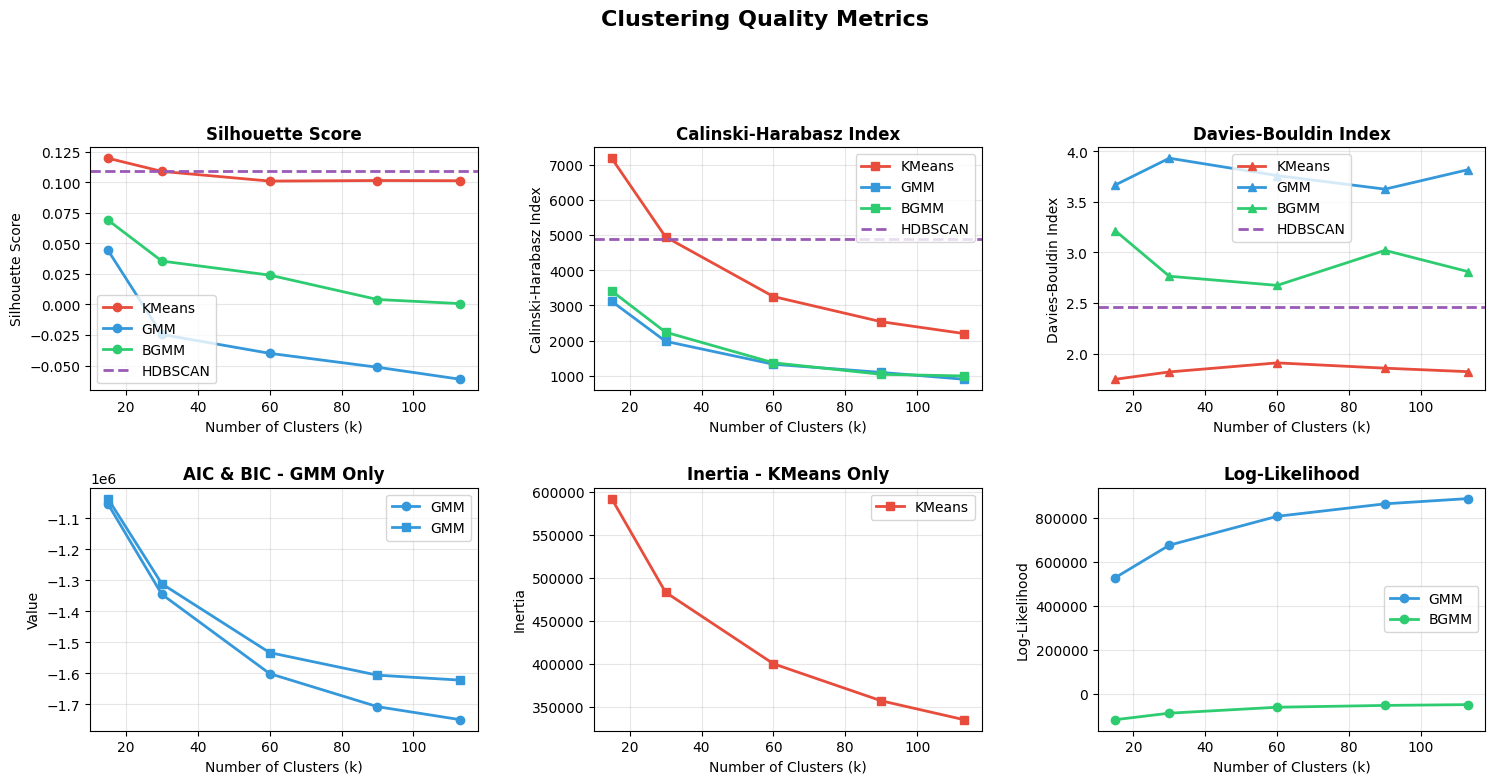

In [ ]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)
algorithms_k_based = ['KMeans', 'GMM', 'BGMM']
colors = {'KMeans': '#e74c3c', 'GMM': '#3498db', 'BGMM': '#2ecc71', 'HDBSCAN': '#9b59b6'}

#Plot
def plot_k_based_metric(ax, metric_col, title, ylabel, marker):

    #1. Plot k based metrics
    df_rip_k = df_rip[df_rip['Algorithm'].isin(algorithms_k_based)]
    for algo in algorithms_k_based:
        data = df_rip_k[df_rip_k['Algorithm'] == algo]
        ax.plot(data['n_clusters'], data[metric_col], marker=marker,
                linewidth=2, label=algo, color=colors[algo])

    #2. Plot HDBSCAN
    df_rip_hdbscan = df_rip[df_rip['Algorithm'] == 'HDBSCAN']
    if not df_rip_hdbscan.empty and metric_col in df_rip_hdbscan.columns:
        # Nota: HDBSCAN solo tiene una fila (un valor)
        hdbscan_value = df_rip_hdbscan[metric_col].values[0]
        ax.axhline(y=hdbscan_value, color=colors['HDBSCAN'], linestyle='--',
                   linewidth=2, label='HDBSCAN')

    ax.set_xlabel('Number of Clusters (k)')
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

ax1 = fig.add_subplot(gs[0, 0])
plot_k_based_metric(ax1, 'Silhouette', 'Silhouette Score', 'Silhouette Score', 'o')

ax2 = fig.add_subplot(gs[0, 1])
plot_k_based_metric(ax2, 'Calinski_Harabasz', 'Calinski-Harabasz Index', 'Calinski-Harabasz Index', 's')

ax3 = fig.add_subplot(gs[0, 2])
plot_k_based_metric(ax3, 'Davies_Bouldin', 'Davies-Bouldin Index', 'Davies-Bouldin Index', '^')


data_gmm = df_rip[df_rip['Algorithm'] == 'GMM']
data_km = df_rip[df_rip['Algorithm'] == 'KMeans']
data_bgmm = df_rip[df_rip['Algorithm'] == 'BGMM']

#BIC (GMM only)
ax5 = fig.add_subplot(gs[1, 0])
ax5.plot(data_gmm['n_clusters'], data_gmm['AIC'], marker='o', linewidth=2, color=colors['GMM'], label='GMM')
ax5.plot(data_gmm['n_clusters'], data_gmm['BIC'], marker='s', linewidth=2, color=colors['GMM'], label='GMM')
ax5.set_xlabel('Number of Clusters (k)')
ax5.set_ylabel('Value')
ax5.set_title('AIC & BIC - GMM Only', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

#Inertia (KMeans only)
ax6 = fig.add_subplot(gs[1, 1])
if not data_km.empty:
    ax6.plot(data_km['n_clusters'], data_km['Inertia'], marker='s', linewidth=2, color=colors['KMeans'], label='KMeans')
ax6.set_xlabel('Number of Clusters (k)')
ax6.set_ylabel('Inertia')
ax6.set_title('Inertia - KMeans Only', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

#Log-Likelihood (GMM and BGMM)
ax7 = fig.add_subplot(gs[1, 2])
for algo in ['GMM', 'BGMM']:
    data = df_rip[df_rip['Algorithm'] == algo]
    if not data.empty:
        ax7.plot(data['n_clusters'], data['Log_Likelihood'], marker='o', linewidth=2, label=algo, color=colors[algo])
ax7.set_xlabel('Number of Clusters (k)')
ax7.set_ylabel('Log-Likelihood')
ax7.set_title('Log-Likelihood', fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

plt.suptitle('Clustering Quality Metrics', fontsize=16, fontweight='bold', y=0.995)
plt.show()

In [ ]:
#Summary of best k for each algorithm and metric
summary = []
for algo in ['KMeans', 'GMM', 'BGMM']:
    algo_data = df_k_based[df_k_based['Algorithm'] == algo]
    best_silhouette_k = algo_data.loc[algo_data['Silhouette'].idxmax(), 'n_clusters']
    best_ch_k = algo_data.loc[algo_data['Calinski_Harabasz'].idxmax(), 'n_clusters']
    best_db_k = algo_data.loc[algo_data['Davies_Bouldin'].idxmin(), 'n_clusters']

    summary.append({
        'Algorithm': algo,
        'Best k (Silhouette)': int(best_silhouette_k),
        'Best k (Calinski-Harabasz)': int(best_ch_k),
        'Best k (Davies-Bouldin)': int(best_db_k),
        'Silhouette Score': f"{algo_data['Silhouette'].max():.3f}",
        'CH Score': f"{algo_data['Calinski_Harabasz'].max():.1f}",
        'DB Score': f"{algo_data['Davies_Bouldin'].min():.3f}"})

    # Add GMM AIC/BIC info
    gmm_data = df_k_based[df_k_based['Algorithm'] == 'GMM']
    best_aic_k = gmm_data.loc[gmm_data['AIC'].idxmin(), 'n_clusters']
    best_bic_k = gmm_data.loc[gmm_data['BIC'].idxmin(), 'n_clusters']


    summary_df = pd.DataFrame(summary)
    print(summary_df.to_string(index=False))

    print(f"\nGMM Specific:")
    print(f"  - Best k (AIC): {int(best_aic_k)}")
    print(f"  - Best k (BIC): {int(best_bic_k)}")

    # HDBSCAN info
    if 'HDBSCAN' in results_df['Algorithm'].values:
        hdb_data = results_df[results_df['Algorithm'] == 'HDBSCAN'].iloc[0]
        print(f"\nHDBSCAN (automatic):")
        print(f"  - Detected clusters: {int(hdb_data['Effective_Clusters'])}")
        print(f"  - Silhouette: {hdb_data['Silhouette']:.3f}")
        print(f"  - Calinski-Harabasz: {hdb_data['Calinski_Harabasz']:.1f}")
        print(f"  - Davies-Bouldin: {hdb_data['Davies_Bouldin']:.3f}")

    print("="*80 + "\n")

Algorithm  Best k (Silhouette)  Best k (Calinski-Harabasz)  Best k (Davies-Bouldin) Silhouette Score CH Score DB Score
   KMeans                   15                          15                       15            0.120   7185.1    1.746

GMM Specific:
  - Best k (AIC): 113
  - Best k (BIC): 113

Algorithm  Best k (Silhouette)  Best k (Calinski-Harabasz)  Best k (Davies-Bouldin) Silhouette Score CH Score DB Score
   KMeans                   15                          15                       15            0.120   7185.1    1.746
      GMM                   15                          15                       90            0.044   3117.5    3.625

GMM Specific:
  - Best k (AIC): 113
  - Best k (BIC): 113

Algorithm  Best k (Silhouette)  Best k (Calinski-Harabasz)  Best k (Davies-Bouldin) Silhouette Score CH Score DB Score
   KMeans                   15                          15                       15            0.120   7185.1    1.746
      GMM                   15                 